In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

import tensorflow as tf
from setup_mnist import MNIST
from setup_cifar import CIFAR
import os

def train(data, file_name, params, num_epochs=30, batch_size=50, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (5, 5), padding='same',
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Conv2D(params[1], (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Conv2D(params[2], (4, 4), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Flatten())
    model.add(Dense(10))
    
    model.summary()

    
    
#     model.add(Conv2D(params[2], (3, 3)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(params[3], (3, 3)))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Flatten())
#     model.add(Dense(params[4]))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(params[5]))
#     model.add(Activation('relu'))
#     model.add(Dense(10))
    
    if init != None:
        model.load_weights(init)

    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                       logits=predicted/train_temp)

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              epochs=num_epochs,
              shuffle=True)
    

    if file_name != None:
        model.save(file_name)

    return model

def train_distillation(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1):
    """
    Train a network using defensive distillation.
    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
    if not os.path.exists(file_name+"_init"):
        # Train for one epoch to get a good starting point.
        train(data, file_name+"_init", params, 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train(data, file_name+"_teacher", params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # evaluate the labels at temperature t
    predicted = teacher.predict(data.train_data)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        print(y)
        data.train_labels = y

    # train the student model at temperature t
    student = train(data, file_name, params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # and finally we predict at temperature 1
    predicted = student.predict(data.train_data)

    print(predicted)

/home/tianwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# if not os.path.isdir('models'):
#     os.makedirs('models')

# # train(CIFAR(), "models/cifar", [64, 64, 128, 128, 256, 256], num_epochs=50)
# hidden_param = [10, 25, 100]
# train(MNIST(), "models/mnist", hidden_param, num_epochs=30)
# train_distillation(MNIST(), "models/mnist-distilled-100", hidden_param,
#                    num_epochs=30, train_temp=100)

In [3]:
import tensorflow as tf
import numpy as np
import time

from setup_cifar import CIFAR, CIFARModel
from setup_mnist import MNIST, MNISTModel
from setup_inception import ImageNet, InceptionModel

from l2_attack import CarliniL2
from l0_attack import CarliniL0
from li_attack import CarliniLi


# def show(img):
#     """
#     Show MNSIT digits in the console.
#     """
#     remap = "  .*#"+"#"*100
#     img = (img.flatten()+.5)*3
#     if len(img) != 784: return
#     print("START")
#     for i in range(28):
#         print("".join([remap[int(round(x))] for x in img[i*28:i*28+28]]))


def generate_data(data, samples, targeted=True, start=0, inception=False):
    """
    Generate the input data to the attack algorithm.
    data: the images to attack
    samples: number of samples to use
    targeted: if true, construct targeted attacks, otherwise untargeted attacks
    start: offset into data to use
    inception: if targeted and inception, randomly sample 100 targets intead of 1000
    """
    inputs = []
    targets = []
    for i in range(samples):
        if targeted:
            if inception:
                seq = random.sample(range(1,1001), 10)
            else:
                seq = range(data.test_labels.shape[1])

            for j in seq:
                if (j == np.argmax(data.test_labels[start+i])) and (inception == False):
                    continue
                inputs.append(data.test_data[start+i])
                targets.append(np.eye(data.test_labels.shape[1])[j])
        else:
            inputs.append(data.test_data[start+i])
            targets.append(data.test_labels[start+i])

    inputs = np.array(inputs)
    targets = np.array(targets)

    return inputs, targets

In [4]:
# sess = tf.Session()
# tf.global_variables_initializer().run()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
# sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

data, model =  MNIST(), MNISTModel("models/mnist", sess)
attack = CarliniL0(sess, model,  max_iterations=100)
# attack = CarliniL2(sess, model, batch_size=9, max_iterations=1000, confidence=0)

inputs, targets = generate_data(data, samples=1, targeted=True,
                                start=0, inception=False)

In [5]:
print(inputs.shape )
print(targets )

(9, 28, 28, 1)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [6]:
timestart = time.time()
adv = attack.attack(inputs, targets)
timeend = time.time()

print("Took",timeend-timestart,"seconds to run",len(inputs),"samples.")

Attack iteration 0
try const 0.001
0 [40.22787] 0.0
10 [40.04512] 0.00027763582
20 [40.05693] 0.00016088602
30 [40.082035] 9.2370974e-05
40 [40.094997] 7.2000534e-05
50 [40.095684] 6.897059e-05
60 [40.09607] 6.784852e-05
70 [40.099247] 6.434549e-05
80 [40.098755] 6.4733395e-05
90 [40.098698] 6.473586e-05
try const 0.002
0 [40.098965] 6.444137e-05
10 [39.95512] 0.00030497203
20 [39.978554] 0.00024794752
30 [39.97995] 0.00024088158
40 [39.976437] 0.0002467441
50 [39.975994] 0.00024702155
60 [39.974087] 0.00025058666
70 [39.97447] 0.00024964096
80 [39.973927] 0.0002506286
90 [39.97362] 0.00025114723
try const 0.004
0 [39.973553] 0.00025122514
10 [39.690506] 0.0011973744
20 [39.746513] 0.00094434374
30 [39.756485] 0.0008932388
40 [39.746914] 0.000926232
50 [39.743195] 0.0009396453
60 [39.74608] 0.0009268878
70 [39.74579] 0.00092740485
80 [39.74333] 0.00093682174
90 [39.744316] 0.0009325016
try const 0.008
0 [39.744843] 0.00093010475
10 [39.278458] 0.003898758
20 [39.314434] 0.0035466426
30

0 [0.03930641] 6.7009664
Forced equal: 451.0 Equal count: 333
Now forced equal: 457.0
try const 0.512
0 [0.] 6.588912
Forced equal: 457.0 Equal count: 327
Now forced equal: 463.0
try const 0.512
0 [0.] 6.5825486
Forced equal: 463.0 Equal count: 321
Now forced equal: 469.0
try const 0.512
0 [0.] 6.5756254
Forced equal: 469.0 Equal count: 315
Now forced equal: 475.0
try const 0.512
0 [0.] 6.56719
Forced equal: 475.0 Equal count: 309
Now forced equal: 481.0
try const 0.512
0 [0.] 6.5583186
Forced equal: 481.0 Equal count: 303
Now forced equal: 487.0
try const 0.512
0 [0.06203962] 6.550041
Forced equal: 487.0 Equal count: 297
Now forced equal: 493.0
try const 0.512
0 [0.08359361] 6.514036
Forced equal: 493.0 Equal count: 291
Now forced equal: 499.0
try const 0.512
0 [0.] 6.6094894
Forced equal: 499.0 Equal count: 285
Now forced equal: 505.0
try const 0.512
0 [0.] 6.5983663
Forced equal: 505.0 Equal count: 279
Now forced equal: 511.0
try const 0.512
0 [0.00697351] 6.586626
Forced equal: 511

Forced equal: 718.0 Equal count: 66
Now forced equal: 719.0
try const 1.024
0 [0.] 10.478823
Forced equal: 719.0 Equal count: 65
Now forced equal: 720.0
try const 1.024
0 [0.23081042] 10.420246
Forced equal: 720.0 Equal count: 64
Now forced equal: 721.0
try const 1.024
0 [0.14840914] 10.503084
Forced equal: 721.0 Equal count: 63
Now forced equal: 722.0
try const 1.024
0 [0.09545542] 10.611845
Forced equal: 722.0 Equal count: 62
Now forced equal: 723.0
try const 1.024
0 [0.19310881] 10.722239
Forced equal: 723.0 Equal count: 61
Now forced equal: 724.0
try const 1.024
0 [0.66098046] 10.77601
Forced equal: 724.0 Equal count: 60
Now forced equal: 725.0
try const 1.024
0 [0.11211611] 11.120959
Forced equal: 725.0 Equal count: 59
Now forced equal: 726.0
try const 1.024
0 [0.05776382] 11.216822
Forced equal: 726.0 Equal count: 58
Now forced equal: 727.0
try const 1.024
0 [0.] 11.349643
Forced equal: 727.0 Equal count: 57
Now forced equal: 728.0
try const 1.024
0 [0.5290811] 11.229801
Forced e

80 [0.9464834] 26.542912
90 [0.9464834] 26.543026
try const 67108.864
0 [0.9464891] 26.5438
10 [0.9464929] 26.5444
20 [0.94656825] 26.554638
30 [0.946512] 26.547085
40 [0.94648147] 26.542978
50 [0.9464977] 26.545183
60 [0.9464805] 26.54364
70 [0.9464834] 26.543808
80 [0.9464729] 26.54079
90 [0.9464891] 26.540194
try const 134217.728
0 [0.9464643] 26.541475
10 [0.9464929] 26.54497
20 [0.94647956] 26.54324
30 [0.9465091] 26.546926
40 [0.94649863] 26.545622
50 [0.9464719] 26.541908
60 [0.94647] 26.541824
70 [0.94651294] 26.547276
80 [0.94647956] 26.543262
90 [0.94646907] 26.541958
try const 268435.456
0 [0.94646907] 26.540981
10 [0.94647574] 26.542759
20 [0.9465196] 26.548038
30 [0.94651103] 26.547064
40 [0.9464853] 26.543781
50 [0.9464767] 26.542904
60 [0.9465196] 26.538975
70 [0.9464729] 26.542519
80 [0.94648147] 26.543653
90 [0.9464996] 26.546158
try const 536870.912
0 [0.94647574] 26.54301
10 [0.9465034] 26.54671
20 [0.94651294] 26.539293
30 [0.9464977] 26.539862
40 [0.9464843] 26.540

Forced equal: 433.0 Equal count: 351
Now forced equal: 439.0
try const 0.512
0 [0.07084013] 7.750883
Forced equal: 439.0 Equal count: 345
Now forced equal: 445.0
try const 0.512
0 [0.] 7.7886662
Forced equal: 445.0 Equal count: 339
Now forced equal: 451.0
try const 0.512
0 [0.] 7.788069
Forced equal: 451.0 Equal count: 333
Now forced equal: 457.0
try const 0.512
0 [0.] 7.7871814
Forced equal: 457.0 Equal count: 327
Now forced equal: 463.0
try const 0.512
0 [0.] 7.781364
Forced equal: 463.0 Equal count: 321
Now forced equal: 469.0
try const 0.512
0 [0.] 7.7799172
Forced equal: 469.0 Equal count: 315
Now forced equal: 475.0
try const 0.512
0 [0.] 7.7782006
Forced equal: 475.0 Equal count: 309
Now forced equal: 481.0
try const 0.512
0 [0.] 7.77615
Forced equal: 481.0 Equal count: 303
Now forced equal: 487.0
try const 0.512
0 [0.] 7.7690673
Forced equal: 487.0 Equal count: 297
Now forced equal: 493.0
try const 0.512
0 [0.01428867] 7.7660494
Forced equal: 493.0 Equal count: 291
Now forced e

Forced equal: 707.0 Equal count: 77
Now forced equal: 708.0
try const 0.512
0 [0.17392708] 9.276121
10 [0.0114286] 9.301405
Forced equal: 708.0 Equal count: 76
Now forced equal: 709.0
try const 0.512
0 [0.17590977] 9.257611
Forced equal: 709.0 Equal count: 75
Now forced equal: 710.0
try const 0.512
0 [0.20331265] 9.296934
Forced equal: 710.0 Equal count: 74
Now forced equal: 711.0
try const 0.512
0 [0.10000301] 9.403763
Forced equal: 711.0 Equal count: 73
Now forced equal: 712.0
try const 0.512
0 [0.3972447] 9.5103855
10 [0.8573735] 9.059101
20 [0.6968682] 9.119129
30 [0.3459785] 9.275095
40 [0.1684611] 9.348821
50 [0.19224812] 9.33813
60 [0.19749619] 9.333769
70 [0.20313431] 9.329628
80 [0.078789] 9.38692
90 [0.18151118] 9.339563
try const 1.024
0 [0.23604657] 9.319671
Forced equal: 712.0 Equal count: 72
Now forced equal: 713.0
try const 1.024
0 [0.18766905] 9.482819
Forced equal: 713.0 Equal count: 71
Now forced equal: 714.0
try const 1.024
0 [0.16027428] 9.49769
Forced equal: 714.0 

20 [1.6329334] 21.579283
30 [1.6295574] 21.579466
40 [1.6292579] 21.573708
50 [1.6283395] 21.587633
60 [1.6252143] 21.585567
70 [1.6299417] 21.579597
80 [1.6272104] 21.596638
90 [1.62621] 21.597599
try const 4194.304
0 [1.6231] 21.588837
10 [1.6247098] 21.60047
20 [1.6203277] 21.594795
30 [1.6211946] 21.60091
40 [1.6241043] 21.595106
50 [1.6218097] 21.607124
60 [1.6182878] 21.601788
70 [1.6185234] 21.605421
80 [1.6196716] 21.602901
90 [1.6186788] 21.60876
try const 8388.608
0 [1.6200769] 21.612846
10 [1.6211507] 21.604029
20 [1.6199701] 21.616047
30 [1.6195743] 21.617224
40 [1.6154859] 21.610966
50 [1.6165826] 21.6112
60 [1.6193511] 21.609283
70 [1.6224859] 21.607624
80 [1.6207864] 21.60965
90 [1.6150234] 21.615387
try const 16777.216
0 [1.616719] 21.619246
10 [1.619684] 21.611914
20 [1.617521] 21.623129
30 [1.6186073] 21.61362
40 [1.6154392] 21.620808
50 [1.6157205] 21.622097
60 [1.6162298] 21.623585
70 [1.6167018] 21.62521
80 [1.618119] 21.615162
90 [1.6154487] 21.623814
try const 33

Forced equal: 246.0 Equal count: 353
Now forced equal: 252.0
try const 0.256
0 [0.] 4.076437
Forced equal: 252.0 Equal count: 354
Now forced equal: 258.0
try const 0.256
0 [0.] 4.076442
Forced equal: 258.0 Equal count: 354
Now forced equal: 264.0
try const 0.256
0 [0.] 4.076447
Forced equal: 264.0 Equal count: 354
Now forced equal: 270.0
try const 0.256
0 [0.] 4.0764523
Forced equal: 270.0 Equal count: 354
Now forced equal: 276.0
try const 0.256
0 [0.] 4.076457
Forced equal: 276.0 Equal count: 354
Now forced equal: 282.0
try const 0.256
0 [0.] 4.0764627
Forced equal: 282.0 Equal count: 354
Now forced equal: 288.0
try const 0.256
0 [0.] 4.0764685
Forced equal: 288.0 Equal count: 354
Now forced equal: 294.0
try const 0.256
0 [0.] 4.076473
Forced equal: 294.0 Equal count: 354
Now forced equal: 300.0
try const 0.256
0 [0.] 4.076478
Forced equal: 300.0 Equal count: 354
Now forced equal: 306.0
try const 0.256
0 [0.] 4.0764832
Forced equal: 306.0 Equal count: 354
Now forced equal: 312.0
try c

Forced equal: 713.0 Equal count: 71
Now forced equal: 714.0
try const 0.512
0 [0.12205578] 5.305811
Forced equal: 714.0 Equal count: 70
Now forced equal: 715.0
try const 0.512
0 [0.01728703] 5.4235554
Forced equal: 715.0 Equal count: 69
Now forced equal: 716.0
try const 0.512
0 [0.] 5.526245
Forced equal: 716.0 Equal count: 68
Now forced equal: 717.0
try const 0.512
0 [0.] 5.4950314
Forced equal: 717.0 Equal count: 67
Now forced equal: 718.0
try const 0.512
0 [0.14425637] 5.4611955
Forced equal: 718.0 Equal count: 66
Now forced equal: 719.0
try const 0.512
0 [0.] 5.5657167
Forced equal: 719.0 Equal count: 65
Now forced equal: 720.0
try const 0.512
0 [0.] 5.542233
Forced equal: 720.0 Equal count: 64
Now forced equal: 721.0
try const 0.512
0 [0.23436238] 5.5060954
Forced equal: 721.0 Equal count: 63
Now forced equal: 722.0
try const 0.512
0 [0.] 5.607798
Forced equal: 722.0 Equal count: 62
Now forced equal: 723.0
try const 0.512
0 [0.13255669] 5.5807023
Forced equal: 723.0 Equal count: 6

70 [2.8372648] 14.62075
80 [2.837221] 14.620814
90 [2.8371847] 14.6208725
try const 524.288
0 [2.8371484] 14.620921
10 [2.8371055] 14.620983
20 [2.8370655] 14.621048
30 [2.8370283] 14.62111
40 [2.83699] 14.621161
50 [2.8369615] 14.621205
60 [2.8369358] 14.6212435
70 [2.8369129] 14.621276
80 [2.8368938] 14.6213045
90 [2.8368795] 14.621329
try const 1048.576
0 [2.8368604] 14.621351
10 [2.8368404] 14.621378
20 [2.8368223] 14.621409
30 [2.8368032] 14.621435
40 [2.8367822] 14.621459
50 [2.8367698] 14.621479
60 [2.8367631] 14.621496
70 [2.8367517] 14.6215105
80 [2.836743] 14.621524
90 [2.8367326] 14.621534
try const 2097.152
0 [2.8367298] 14.621544
10 [2.8367193] 14.621556
20 [2.8367107] 14.621571
30 [2.8367012] 14.621584
40 [2.8366992] 14.621593
50 [2.8366907] 14.621603
60 [2.836686] 14.621611
70 [2.836684] 14.621616
80 [2.8366773] 14.621623
90 [2.8366773] 14.621628
try const 4194.304
0 [2.8366678] 14.621634
10 [2.836665] 14.621638
20 [2.836661] 14.621645
30 [2.8366573] 14.621651
40 [2.8366

Forced equal: 264.0 Equal count: 282
Now forced equal: 270.0
try const 0.128
0 [0.] 1.73359
Forced equal: 270.0 Equal count: 282
Now forced equal: 276.0
try const 0.128
0 [0.] 1.7335929
Forced equal: 276.0 Equal count: 282
Now forced equal: 282.0
try const 0.128
0 [0.] 1.7335955
Forced equal: 282.0 Equal count: 282
Now forced equal: 288.0
try const 0.128
0 [0.] 1.7335985
Forced equal: 288.0 Equal count: 282
Now forced equal: 294.0
try const 0.128
0 [0.] 1.7336009
Forced equal: 294.0 Equal count: 282
Now forced equal: 300.0
try const 0.128
0 [0.] 1.7336037
Forced equal: 300.0 Equal count: 282
Now forced equal: 306.0
try const 0.128
0 [0.] 1.7336065
Forced equal: 306.0 Equal count: 282
Now forced equal: 312.0
try const 0.128
0 [0.] 1.733609
Forced equal: 312.0 Equal count: 282
Now forced equal: 318.0
try const 0.128
0 [0.] 1.7336118
Forced equal: 318.0 Equal count: 282
Now forced equal: 324.0
try const 0.128
0 [0.] 1.7336143
Forced equal: 324.0 Equal count: 283
Now forced equal: 330.0
tr

Forced equal: 742.0 Equal count: 42
Now forced equal: 743.0
try const 0.256
0 [0.] 2.3158844
Forced equal: 743.0 Equal count: 41
Now forced equal: 744.0
try const 0.256
0 [0.01713348] 2.2993674
Forced equal: 744.0 Equal count: 40
Now forced equal: 745.0
try const 0.256
0 [0.00297714] 2.3295639
Forced equal: 745.0 Equal count: 39
Now forced equal: 746.0
try const 0.256
0 [0.] 2.358135
Forced equal: 746.0 Equal count: 38
Now forced equal: 747.0
try const 0.256
0 [0.2429979] 2.3330748
Forced equal: 747.0 Equal count: 37
Now forced equal: 748.0
try const 0.256
0 [0.06243683] 2.3786044
Forced equal: 748.0 Equal count: 36
Now forced equal: 749.0
try const 0.256
0 [0.05033661] 2.4045873
Forced equal: 749.0 Equal count: 35
Now forced equal: 750.0
try const 0.256
0 [0.] 2.4340568
Forced equal: 750.0 Equal count: 34
Now forced equal: 751.0
try const 0.256
0 [0.17399193] 2.4102356
Forced equal: 751.0 Equal count: 33
Now forced equal: 752.0
try const 0.256
0 [0.07363869] 2.4475338
Forced equal: 75

try const 67108.864
0 [1.247278] 6.8390574
10 [1.247278] 6.839058
20 [1.247278] 6.8390574
30 [1.2472761] 6.839058
40 [1.2472761] 6.8390574
50 [1.2472723] 6.839058
60 [1.2472723] 6.8390584
70 [1.2472723] 6.8390584
80 [1.2472723] 6.8390584
90 [1.2472684] 6.8390584
try const 134217.728
0 [1.2472684] 6.8390584
10 [1.2472684] 6.8390584
20 [1.2472703] 6.8390584
30 [1.2472703] 6.8390584
40 [1.2472761] 6.8390584
50 [1.2472761] 6.8390584
60 [1.2472742] 6.8390584
70 [1.2472742] 6.8390584
80 [1.2472742] 6.8390584
90 [1.2472742] 6.8390584
try const 268435.456
0 [1.2472742] 6.8390584
10 [1.2472742] 6.8390584
20 [1.2472742] 6.8390584
30 [1.2472723] 6.8390584
40 [1.2472723] 6.8390584
50 [1.2472684] 6.839059
60 [1.2472684] 6.8390584
70 [1.2472723] 6.839059
80 [1.2472723] 6.839059
90 [1.2472723] 6.839059
try const 536870.912
0 [1.2472723] 6.8390584
10 [1.2472723] 6.839059
20 [1.2472723] 6.839059
30 [1.2472723] 6.8390584
40 [1.2472723] 6.839059
50 [1.2472723] 6.839059
60 [1.2472723] 6.8390584
70 [1.2472

Forced equal: 348.0 Equal count: 387
Now forced equal: 354.0
try const 0.512
0 [0.] 5.9976263
Forced equal: 354.0 Equal count: 387
Now forced equal: 360.0
try const 0.512
0 [0.] 5.9976344
Forced equal: 360.0 Equal count: 387
Now forced equal: 366.0
try const 0.512
0 [0.] 5.9976416
Forced equal: 366.0 Equal count: 387
Now forced equal: 372.0
try const 0.512
0 [0.] 5.99765
Forced equal: 372.0 Equal count: 387
Now forced equal: 378.0
try const 0.512
0 [0.] 5.9976587
Forced equal: 378.0 Equal count: 387
Now forced equal: 384.0
try const 0.512
0 [0.] 5.9976664
Forced equal: 384.0 Equal count: 387
Now forced equal: 390.0
try const 0.512
0 [0.] 5.9976735
Forced equal: 390.0 Equal count: 387
Now forced equal: 396.0
try const 0.512
0 [0.] 5.9976816
Forced equal: 396.0 Equal count: 387
Now forced equal: 402.0
try const 0.512
0 [0.] 5.99769
Forced equal: 402.0 Equal count: 382
Now forced equal: 408.0
try const 0.512
0 [0.] 5.9976974
Forced equal: 408.0 Equal count: 376
Now forced equal: 414.0
try

try const 1.024
0 [0.01478411] 8.71971
Forced equal: 702.0 Equal count: 82
Now forced equal: 703.0
try const 1.024
0 [0.] 8.874523
Forced equal: 703.0 Equal count: 81
Now forced equal: 704.0
try const 1.024
0 [0.05559088] 8.825781
Forced equal: 704.0 Equal count: 80
Now forced equal: 705.0
try const 1.024
0 [0.] 8.952459
Forced equal: 705.0 Equal count: 79
Now forced equal: 706.0
try const 1.024
0 [0.15645434] 8.900303
Forced equal: 706.0 Equal count: 78
Now forced equal: 707.0
try const 1.024
0 [0.] 9.026197
Forced equal: 707.0 Equal count: 77
Now forced equal: 708.0
try const 1.024
0 [0.0960343] 8.970224
Forced equal: 708.0 Equal count: 76
Now forced equal: 709.0
try const 1.024
0 [0.06965614] 9.000298
Forced equal: 709.0 Equal count: 75
Now forced equal: 710.0
try const 1.024
0 [0.] 9.154755
Forced equal: 710.0 Equal count: 74
Now forced equal: 711.0
try const 1.024
0 [0.11785198] 9.094662
Forced equal: 711.0 Equal count: 73
Now forced equal: 712.0
try const 1.024
0 [0.35586715] 9.1

try const 1048.576
0 [0.3957851] 23.422668
10 [0.39725852] 23.432676
20 [0.40163636] 23.477034
30 [0.39114642] 23.4832
40 [0.38394618] 23.496056
50 [0.38373303] 23.495253
60 [0.38717103] 23.530315
70 [0.38196588] 23.54309
80 [0.37358165] 23.534317
90 [0.37266612] 23.54324
try const 2097.152
0 [0.37959743] 23.575418
10 [0.37363267] 23.581627
20 [0.39159465] 23.610403
30 [0.366297] 23.585938
40 [0.36786962] 23.597046
50 [0.364599] 23.606485
60 [0.36566758] 23.605581
70 [0.3594253] 23.62304
80 [0.36334443] 23.63165
90 [0.3589499] 23.630459
try const 4194.304
0 [0.36205363] 23.648716
10 [0.3669932] 23.65498
20 [0.36589026] 23.658508
30 [0.37730193] 23.627514
40 [0.3764212] 23.622395
50 [0.37355494] 23.63196
60 [0.38202024] 23.632713
70 [0.3788798] 23.633669
80 [0.3688376] 23.651329
90 [0.3522613] 23.678396
try const 8388.608
0 [0.35399842] 23.67908
10 [0.35716176] 23.67744
20 [0.3619697] 23.676609
30 [0.36713862] 23.708494
40 [0.35507894] 23.690435
50 [0.35094714] 23.70018
60 [0.35526872] 

Forced equal: 350.0 Equal count: 412
Now forced equal: 357.0
try const 0.256
0 [0.] 3.8654249
Forced equal: 357.0 Equal count: 412
Now forced equal: 364.0
try const 0.256
0 [0.] 3.8654294
Forced equal: 364.0 Equal count: 412
Now forced equal: 371.0
try const 0.256
0 [0.] 3.8654344
Forced equal: 371.0 Equal count: 412
Now forced equal: 378.0
try const 0.256
0 [0.] 3.8654394
Forced equal: 378.0 Equal count: 406
Now forced equal: 385.0
try const 0.256
0 [0.] 3.865444
Forced equal: 385.0 Equal count: 399
Now forced equal: 391.0
try const 0.256
0 [0.] 3.8654473
Forced equal: 391.0 Equal count: 393
Now forced equal: 397.0
try const 0.256
0 [0.] 3.8653908
Forced equal: 397.0 Equal count: 387
Now forced equal: 403.0
try const 0.256
0 [0.] 3.8653338
Forced equal: 403.0 Equal count: 381
Now forced equal: 409.0
try const 0.256
0 [0.] 3.865306
Forced equal: 409.0 Equal count: 375
Now forced equal: 415.0
try const 0.256
0 [0.] 3.8652902
Forced equal: 415.0 Equal count: 369
Now forced equal: 421.0
t

Forced equal: 727.0 Equal count: 57
Now forced equal: 728.0
try const 0.512
0 [0.] 5.5662847
Forced equal: 728.0 Equal count: 56
Now forced equal: 729.0
try const 0.512
0 [0.16280724] 5.5287967
Forced equal: 729.0 Equal count: 55
Now forced equal: 730.0
try const 0.512
0 [0.] 5.6408615
Forced equal: 730.0 Equal count: 54
Now forced equal: 731.0
try const 0.512
0 [0.] 5.606716
Forced equal: 731.0 Equal count: 53
Now forced equal: 732.0
try const 0.512
0 [0.16281106] 5.5663023
Forced equal: 732.0 Equal count: 52
Now forced equal: 733.0
try const 0.512
0 [0.] 5.6980877
Forced equal: 733.0 Equal count: 51
Now forced equal: 734.0
try const 0.512
0 [0.15892483] 5.6582966
Forced equal: 734.0 Equal count: 50
Now forced equal: 735.0
try const 0.512
0 [0.36914802] 5.750818
Forced equal: 735.0 Equal count: 49
Now forced equal: 736.0
try const 0.512
0 [0.1188686] 5.7422137
Forced equal: 736.0 Equal count: 48
Now forced equal: 737.0
try const 0.512
0 [0.01017071] 5.83337
Forced equal: 737.0 Equal c

80 [2.8391998] 11.809325
90 [2.8398654] 11.813338
try const 33554.432
0 [2.838267] 11.812122
10 [2.8393686] 11.804172
20 [2.8547332] 11.837804
30 [2.8580606] 11.850892
40 [2.8557308] 11.849572
50 [2.8425415] 11.81117
60 [2.8428447] 11.826546
70 [2.8526056] 11.8492565
80 [2.8523414] 11.850679
90 [2.8399475] 11.826502
try const 67108.864
0 [2.8368137] 11.821264
10 [2.848687] 11.850447
20 [2.8660114] 11.879923
30 [2.8712776] 11.810247
40 [2.838291] 11.82995
50 [2.8549974] 11.86275
60 [2.8472965] 11.852173
70 [2.8366077] 11.833761
80 [2.8436344] 11.83063
90 [2.8391387] 11.84384
try const 134217.728
0 [2.837097] 11.839172
10 [2.8384264] 11.842041
20 [2.844917] 11.855971
30 [2.8360393] 11.837675
40 [2.8436086] 11.858316
50 [2.863157] 11.89059
60 [2.8637102] 11.824324
70 [2.8371122] 11.839232
80 [2.8528373] 11.873091
90 [2.841788] 11.850027
try const 268435.456
0 [2.8471935] 11.867203
10 [2.8399303] 11.849478
20 [2.8384035] 11.853871
30 [2.8374202] 11.853743
40 [2.8363273] 11.850031
50 [2.840

Now forced equal: 421.0
try const 0.512
0 [0.] 9.803234
Forced equal: 421.0 Equal count: 363
Now forced equal: 427.0
try const 0.512
0 [0.] 9.794192
Forced equal: 427.0 Equal count: 357
Now forced equal: 433.0
try const 0.512
0 [0.] 9.785435
Forced equal: 433.0 Equal count: 351
Now forced equal: 439.0
try const 0.512
0 [0.5947852] 9.759054
Forced equal: 439.0 Equal count: 345
Now forced equal: 445.0
try const 0.512
0 [0.] 9.8607645
Forced equal: 445.0 Equal count: 339
Now forced equal: 451.0
try const 0.512
0 [0.] 9.85626
Forced equal: 451.0 Equal count: 333
Now forced equal: 457.0
try const 0.512
0 [0.26355648] 9.831417
Forced equal: 457.0 Equal count: 327
Now forced equal: 463.0
try const 0.512
0 [0.] 9.956301
Forced equal: 463.0 Equal count: 321
Now forced equal: 469.0
try const 0.512
0 [0.] 9.948058
Forced equal: 469.0 Equal count: 315
Now forced equal: 475.0
try const 0.512
0 [0.] 9.940246
Forced equal: 475.0 Equal count: 309
Now forced equal: 481.0
try const 0.512
0 [0.] 9.931215

Forced equal: 685.0 Equal count: 99
Now forced equal: 686.0
try const 0.512
0 [0.03314973] 12.20815
Forced equal: 686.0 Equal count: 98
Now forced equal: 687.0
try const 0.512
0 [0.12486625] 12.286382
Forced equal: 687.0 Equal count: 97
Now forced equal: 688.0
try const 0.512
0 [0.13825013] 12.228172
Forced equal: 688.0 Equal count: 96
Now forced equal: 689.0
try const 0.512
0 [0.19567658] 12.241834
Forced equal: 689.0 Equal count: 95
Now forced equal: 690.0
try const 0.512
0 [0.] 12.377805
Forced equal: 690.0 Equal count: 94
Now forced equal: 691.0
try const 0.512
0 [0.25966454] 12.339654
Forced equal: 691.0 Equal count: 93
Now forced equal: 692.0
try const 0.512
0 [0.4136529] 12.353948
10 [0.05991388] 12.411239
Forced equal: 692.0 Equal count: 92
Now forced equal: 693.0
try const 0.512
0 [0.34030533] 12.414528
10 [0.2053261] 12.391281
20 [0.38176227] 12.28842
30 [0.41211224] 12.244383
40 [0.39774394] 12.250935
50 [0.4412074] 12.224082
60 [0.40795898] 12.253473
70 [0.43040657] 12.2336

50 [1.5993512] 33.707375
60 [1.5944786] 33.730583
70 [1.5917842] 33.75087
80 [1.5872936] 33.76658
90 [1.583936] 33.778687
try const 131.072
0 [1.5849142] 33.786613
10 [1.5786266] 33.812042
20 [1.5732398] 33.82618
30 [1.5694726] 33.84028
40 [1.5716171] 33.862896
50 [1.5719805] 33.87622
60 [1.5631292] 33.873436
70 [1.5612304] 33.878845
80 [1.5663655] 33.896187
90 [1.5640464] 33.898777
try const 262.144
0 [1.5628345] 33.902184
10 [1.5571501] 33.896484
20 [1.5646548] 33.895737
30 [1.5564675] 33.90318
40 [1.5598466] 33.921776
50 [1.5531008] 33.91257
60 [1.5529168] 33.920135
70 [1.5534818] 33.92032
80 [1.5509803] 33.92395
90 [1.5504155] 33.926964
try const 524.288
0 [1.5515893] 33.931145
10 [1.5516999] 33.935787
20 [1.5495524] 33.93719
30 [1.5497365] 33.94408
40 [1.5536594] 33.95588
50 [1.5481899] 33.94965
60 [1.549485] 33.95473
70 [1.5509367] 33.95935
80 [1.54701] 33.95443
90 [1.5527627] 33.951393
try const 1048.576
0 [1.5507889] 33.96483
10 [1.5460532] 33.963158
20 [1.5453603] 33.963314
30

Now forced equal: 192.0
try const 0.256
0 [0.] 4.0980153
Forced equal: 192.0 Equal count: 400
Now forced equal: 198.0
try const 0.256
0 [0.] 4.098022
Forced equal: 198.0 Equal count: 400
Now forced equal: 204.0
try const 0.256
0 [0.] 4.0980287
Forced equal: 204.0 Equal count: 400
Now forced equal: 210.0
try const 0.256
0 [0.] 4.0980353
Forced equal: 210.0 Equal count: 400
Now forced equal: 216.0
try const 0.256
0 [0.] 4.0980425
Forced equal: 216.0 Equal count: 400
Now forced equal: 222.0
try const 0.256
0 [0.] 4.0980496
Forced equal: 222.0 Equal count: 400
Now forced equal: 228.0
try const 0.256
0 [0.] 4.0980563
Forced equal: 228.0 Equal count: 400
Now forced equal: 234.0
try const 0.256
0 [0.] 4.098063
Forced equal: 234.0 Equal count: 400
Now forced equal: 240.0
try const 0.256
0 [0.] 4.09807
Forced equal: 240.0 Equal count: 400
Now forced equal: 246.0
try const 0.256
0 [0.] 4.0980773
Forced equal: 246.0 Equal count: 400
Now forced equal: 252.0
try const 0.256
0 [0.] 4.0980835
Forced 

0 [0.00029446] 5.699416
Forced equal: 690.0 Equal count: 94
Now forced equal: 691.0
try const 0.512
0 [0.12128902] 5.676773
Forced equal: 691.0 Equal count: 93
Now forced equal: 692.0
try const 0.512
0 [0.] 5.767314
Forced equal: 692.0 Equal count: 92
Now forced equal: 693.0
try const 0.512
0 [0.04692817] 5.7383156
Forced equal: 693.0 Equal count: 91
Now forced equal: 694.0
try const 0.512
0 [0.29776168] 5.8171873
Forced equal: 694.0 Equal count: 90
Now forced equal: 695.0
try const 0.512
0 [0.] 5.824909
Forced equal: 695.0 Equal count: 89
Now forced equal: 696.0
try const 0.512
0 [0.1425388] 5.798352
Forced equal: 696.0 Equal count: 88
Now forced equal: 697.0
try const 0.512
0 [0.] 5.8727674
Forced equal: 697.0 Equal count: 87
Now forced equal: 698.0
try const 0.512
0 [0.27153754] 5.812973
Forced equal: 698.0 Equal count: 86
Now forced equal: 699.0
try const 0.512
0 [0.] 5.9143763
Forced equal: 699.0 Equal count: 85
Now forced equal: 700.0
try const 0.512
0 [0.17477871] 5.882641
Force

80 [0.10419536] 20.224756
90 [0.08274818] 20.246357
try const 8.192
0 [0.06586242] 20.270061
10 [0.02930714] 20.404572
Forced equal: 758.0 Equal count: 26
Now forced equal: 760.0
try const 8.192
0 [3.4655483] 18.47226
10 [3.347595] 18.580618
20 [3.2916567] 18.722025
30 [3.2444003] 18.822086
40 [3.2137349] 18.917088
50 [3.1809561] 18.978462
60 [3.1593668] 19.039162
70 [3.1392648] 19.075792
80 [3.1269438] 19.1098
90 [3.1054041] 19.152607
try const 16.384
0 [3.0915086] 19.187752
10 [3.0806267] 19.249144
20 [3.0598953] 19.304209
30 [3.0439336] 19.343197
40 [3.0275285] 19.390001
50 [3.0167053] 19.426622
60 [3.010359] 19.455143
70 [2.9997828] 19.486355
80 [2.9934647] 19.509659
90 [2.9873269] 19.532337
try const 32.768
0 [2.9807713] 19.552914
10 [2.9733012] 19.59195
20 [2.974354] 19.622066
30 [2.953221] 19.685022
40 [2.9447205] 19.72672
50 [2.9366052] 19.756773
60 [2.9328206] 19.779058
70 [2.9361207] 19.78339
80 [2.93109] 19.790672
90 [2.9276555] 19.799623
try const 65.536
0 [2.9274514] 19.79

0 [0.] 2.718956
Forced equal: 138.0 Equal count: 383
Now forced equal: 144.0
try const 0.256
0 [0.] 2.7189612
Forced equal: 144.0 Equal count: 383
Now forced equal: 150.0
try const 0.256
0 [0.] 2.7189665
Forced equal: 150.0 Equal count: 383
Now forced equal: 156.0
try const 0.256
0 [0.] 2.7189715
Forced equal: 156.0 Equal count: 383
Now forced equal: 162.0
try const 0.256
0 [0.] 2.7189765
Forced equal: 162.0 Equal count: 383
Now forced equal: 168.0
try const 0.256
0 [0.] 2.7189817
Forced equal: 168.0 Equal count: 383
Now forced equal: 174.0
try const 0.256
0 [0.] 2.7189865
Forced equal: 174.0 Equal count: 383
Now forced equal: 180.0
try const 0.256
0 [0.] 2.7189918
Forced equal: 180.0 Equal count: 383
Now forced equal: 186.0
try const 0.256
0 [0.] 2.718997
Forced equal: 186.0 Equal count: 383
Now forced equal: 192.0
try const 0.256
0 [0.] 2.7190022
Forced equal: 192.0 Equal count: 383
Now forced equal: 198.0
try const 0.256
0 [0.] 2.719007
Forced equal: 198.0 Equal count: 383
Now force

20 [0.2883594] 2.6999662
30 [0.25915885] 2.7067876
40 [0.28073955] 2.7012434
50 [0.24363305] 2.7110772
60 [0.25889182] 2.706983
70 [0.22792031] 2.7153974
80 [0.2827804] 2.70025
90 [0.2513988] 2.7088673
try const 0.512
0 [0.2554443] 2.7077346
Forced equal: 626.0 Equal count: 158
Now forced equal: 630.0
try const 0.512
0 [0.] 2.8686996
Forced equal: 630.0 Equal count: 154
Now forced equal: 634.0
try const 0.512
0 [0.] 2.8588305
Forced equal: 634.0 Equal count: 150
Now forced equal: 638.0
try const 0.512
0 [0.] 2.8477302
Forced equal: 638.0 Equal count: 146
Now forced equal: 642.0
try const 0.512
0 [0.02522732] 2.833806
Forced equal: 642.0 Equal count: 142
Now forced equal: 646.0
try const 0.512
0 [0.] 2.9299428
Forced equal: 646.0 Equal count: 138
Now forced equal: 650.0
try const 0.512
0 [0.] 2.908626
Forced equal: 650.0 Equal count: 134
Now forced equal: 654.0
try const 0.512
0 [0.11469913] 2.8881545
Forced equal: 654.0 Equal count: 130
Now forced equal: 658.0
try const 0.512
0 [0.] 2.

40 [0.18750073] 8.489302
50 [0.20007302] 8.459265
60 [0.19648816] 8.454055
70 [0.14319588] 8.497916
80 [0.1623695] 8.473488
90 [0.17302205] 8.459683
try const 2.048
0 [0.15649487] 8.471245
Forced equal: 768.0 Equal count: 16
Now forced equal: 769.0
try const 2.048
0 [2.7715232] 7.790336
10 [1.9258859] 8.524039
20 [1.1931112] 9.194716
30 [0.5701368] 9.7978945
40 [0.1015575] 10.3179035
Forced equal: 769.0 Equal count: 15
Now forced equal: 770.0
try const 2.048
0 [0.80812144] 9.944334
10 [0.38916755] 10.454358
20 [0.03534103] 10.898953
Forced equal: 770.0 Equal count: 14
Now forced equal: 771.0
try const 2.048
0 [1.9757001] 10.033589
10 [1.607991] 10.435076
20 [1.3037002] 10.774927
30 [1.0799911] 11.035807
40 [0.91922927] 11.224
50 [0.7925041] 11.367961
60 [0.6815212] 11.492383
70 [0.58331656] 11.599278
80 [0.5033529] 11.68702
90 [0.43954635] 11.759827
try const 4.096
0 [0.38356948] 11.824264
10 [0.29549956] 11.934975
20 [0.20783593] 12.047052
30 [0.14303471] 12.130006
40 [0.09501434] 12.

In [10]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


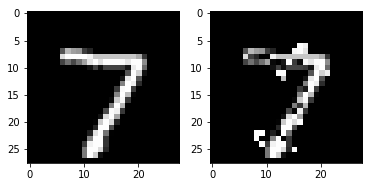

Score: [  8.941851   -6.3095183   3.4985185   7.3974385  -6.135024   -6.1326313
 -19.418959    8.921789   -0.6384908   3.5916631]
output:  0
Total distortion: 4.957866913899313


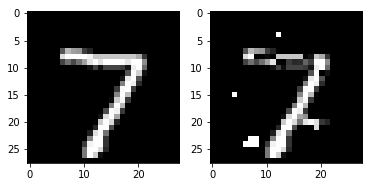

Score: [ -5.9164577   8.347753    8.325979    5.313885    1.6252213  -3.839095
 -19.823454    8.329076   -5.870036   -3.4722676]
output:  1
Total distortion: 4.545339003741695


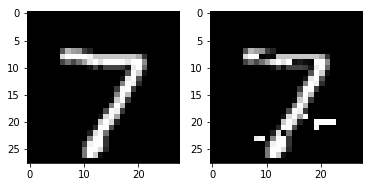

Score: [ -3.7358906   1.7311116  15.693602    2.341644    2.7412407 -10.393496
 -24.696436   15.681869   -3.5563445  -5.266595 ]
output:  2
Total distortion: 3.823149394228321


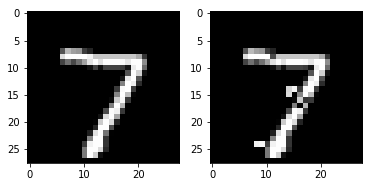

Score: [ -8.560097   -8.2074585  -4.6783805  20.653425   -8.015843   -1.5745429
 -26.456354   20.56083    -4.1119566   8.104397 ]
output:  3
Total distortion: 2.472796154433401


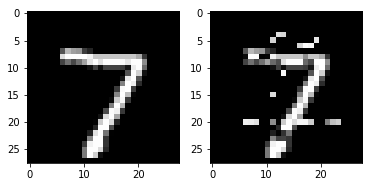

Score: [ -3.294674     0.13102664   5.8620057    5.537006     5.9734178
  -2.510801   -19.46432      5.915548    -4.076673     0.8725344 ]
output:  4
Total distortion: 4.49945934014718


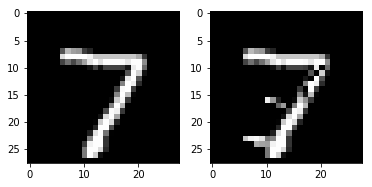

Score: [ -7.4379463  -6.807991   -6.494455   16.718435  -12.175447   16.728367
 -29.0075     16.559885   -3.8273041   8.454272 ]
output:  5
Total distortion: 3.3065587150221107


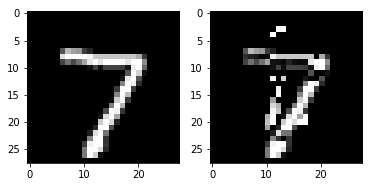

Score: [  4.063908  -10.892207    3.9918904   4.046007   -4.2398806   1.2206572
   4.0769215  -0.3804583   1.5752072  -6.74732  ]
output:  6
Total distortion: 5.572015060744022


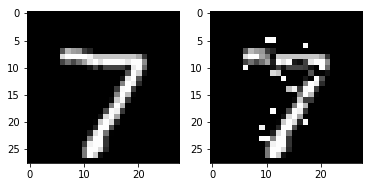

Score: [ -6.701112    -9.005329    -0.5325645    6.761412    -1.8916057
   0.69168687 -13.661348     6.760862     6.7735605    6.1066337 ]
output:  8
Total distortion: 4.5236569682429515


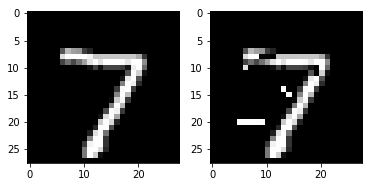

Score: [-13.416456   -5.3245635 -10.906675   13.202188   -3.3763793   7.480514
 -25.155918   15.34449    -6.414921   15.35461  ]
output:  9
Total distortion: 3.5087503313771777


In [11]:


for org_img, adv_img in zip(inputs, adv):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(org_img, (28,28)), cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(adv_img, (28,28)), cmap="gray")
#     plt.colorbar()
    plt.show()
    pred_score = model.model.predict(adv_img.reshape( (1,adv_img.shape[0],adv_img.shape[1],adv_img.shape[2] )))
    print("Score:",pred_score[0])
    print('output: ', np.argmax(pred_score[0]) )
    print("Total distortion:", np.sum((adv_img-org_img)**2)**.5)
    
#     break

In [13]:
file_name = 'L0_attack'
np.savez(file_name, inputs, adv)